In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def generate_sparse_random_array(n, k, g, G, random_state=None):
    """
    Generate a NumPy array of length n with exactly k non-zero entries.
    Non-zero entries are randomly positioned and their values are drawn as:
        sign * magnitude
    where
        - sign is a symmetric Bernoulli random variable in {+1, -1}
        - magnitude is uniformly distributed in [g, G], (G>g>0).
    
    Parameters:
    -----------
    n : int
        Length of the output array.
    k : int
        Number of non-zero entries.
    g : float
        Lower bound for magnitude (must be > 0).
    G : float
        Upper bound for magnitude (must be > g).
    random_state : int, optional
        Seed for NumPy's random number generator (useful for reproducibility).

    Returns:
    --------
    x : numpy.ndarray
        A 1-D array of length n with exactly k non-zero entries.
    """
    if not 0 < g < G:
        raise ValueError("Must have 0 < g < G.")
    if not (0 <= k <= n):
        raise ValueError("k must be between 0 and n (inclusive).")

    rng = np.random.default_rng(random_state)

    # Choose k distinct positions out of n for the non-zero entries
    indices = rng.choice(n, size=k, replace=False)

    # Initialize the array with zeros
    x = np.zeros(n)

    # Generate random signs in {+1, -1}
    signs = rng.choice([1, -1], size=k)

    # Generate random magnitudes uniformly in [g, G]
    magnitudes = rng.uniform(g, G, size=k)

    # Assign the non-zero values
    x[indices] = signs * magnitudes

    return x

In [3]:
def random_orthonormal_matrix(d, n, random_state=None):
    """
    Generate a random d-by-n matrix with orthonormal columns.
    
    Parameters
    ----------
    d : int
        Number of rows. Must be >= n.
    n : int
        Number of columns.
    random_state : int or None, optional
        Seed for reproducibility. If None, no fixed seed is set.
    
    Returns
    -------
    Q : numpy.ndarray
        A d-by-n matrix whose columns are orthonormal.
    """
    if d < n:
        raise ValueError("The number of rows d must be at least the number of columns n.")

    # Create a random generator; use random_state for reproducibility if provided
    rng = np.random.default_rng(random_state)

    # Generate a d-by-n matrix with standard normal entries
    A = rng.standard_normal((d, n))

    # QR decomposition (reduced mode ensures Q is d-by-n)
    Q, R = np.linalg.qr(A, mode='reduced')

    return Q

In [4]:
def random_error(d, n, rho, random_state=None):
    """
    Generate a d-by-n matrix whose columns are sampled uniformly at random
    from the L2-ball of radius rho in R^d.
    
    Parameters
    ----------
    d : int
        Number of rows (dimension of each column).
    n : int
        Number of columns.
    rho : float
        Radius of the L2-ball.
    random_state : int or None, optional
        Random seed for reproducibility.
    
    Returns
    -------
    D : np.ndarray of shape (d, n)
        A matrix whose columns each lie in the ball of radius rho, i.e. ||D[:, i]|| <= rho.
    """
    if rho < 0:
        raise ValueError("rho should be non-negative (usually > 0).")
    
    rng = np.random.default_rng(random_state)
    D = np.zeros((d, n))
    
    for i in range(n):
        # 1. Sample from a standard normal distribution
        v = rng.standard_normal(d)
        
        # 2. Normalize to get a unit direction (handle zero vector case carefully)
        norm_v = np.linalg.norm(v)
        if norm_v == 0:
            # If by chance the vector is exactly 0, just pick any random direction again
            while norm_v == 0:
                v = rng.standard_normal(d)
                norm_v = np.linalg.norm(v)
        
        unit_v = v / norm_v
        
        # 3. Sample a random radius so that it is uniformly distributed in [0, rho]
        #    for a d-dimensional ball. The distribution for the radius is r = rho * u^(1/d),
        #    where u ~ Uniform(0,1).
        u = rng.uniform()
        r = rho * (u ** (1.0 / d))
        
        # 4. Scale the unit direction by r
        D[:, i] = unit_v * r
        
    return D

In [5]:
def top_k_with_mask(y, k):
    """
    Returns:
      z     - a copy of y with all but the top-k (by magnitude) entries set to zero
      mask  - a 0/1 array indicating which entries are kept
    """
    k = min(k, y.size)
    
    # Indices of top-k entries in magnitude
    idx = np.argsort(np.abs(y))[-k:]
    
    # Create mask
    mask = np.zeros_like(y, dtype=float)
    mask[idx] = 1.0
    
    # Create z by masking
    z = y * mask
    return z, mask

In [6]:
def objective_and_gradient(D, D_star, x, k):
    """
    Computes the objective: 0.5 * || D_star * f(D^T x) - x ||^2,
    and its gradient wrt D, for a single input x.
    
    Parameters
    ----------
    D       : (d, n) matrix
    D_star  : (d, n) fixed matrix
    x       : (d,) input vector
    k       : number of largest magnitude entries to keep in the top-k operator
    
    Returns
    -------
    loss   : float
    grad_D : (d, n) the gradient wrt D
    """
    # Forward pass
    y = D.T @ x               # shape = (n,)
    z, mask = top_k_with_mask(y, k)  # z in shape (n,)
    r = D_star @ z            # shape = (d,)
    e = r - x                 # shape = (d,)
    
    # Loss = 0.5 * || e ||^2
    loss = 0.5 * np.dot(e, e)
    
    # Backward pass
    # grad wrt r is e, so grad wrt z is D_star^T e
    grad_z = D_star.T @ e  # shape = (n,)
    
    # Only top-k entries of y have non-zero gradient
    grad_y = grad_z * mask  # shape = (n,)
    
    # Since y = D^T x, grad wrt D = x * (grad_y)^T
    grad_D = np.outer(x, grad_y)
    
    return loss, grad_D, mask

In [7]:
def objective_and_gradient_multi(D, D_star, X, k):
    """
    Computes the SUM of objectives over multiple input vectors X
    and the corresponding SUM of gradients wrt D.
    
    Parameters
    ----------
    D       : (d, n) matrix
    D_star  : (d, n) fixed matrix
    X       : (m, d) array of m input vectors x^{(i)}
    k       : number of largest magnitude entries to keep
    
    Returns
    -------
    total_loss   : float, sum of the losses over all x^{(i)}
    total_grad_D : (d, n), sum of the gradients wrt D over all x^{(i)}
    """
    total_loss = 0.0
    total_grad_D = np.zeros_like(D)
    
    # Loop over each sample x^{(i)}
    for x in X:
        loss_i, grad_i, _ = objective_and_gradient(D, D_star, x, k)
        total_loss += loss_i
        total_grad_D += grad_i
    
    return total_loss, total_grad_D

In [8]:
def euclidean_projection_columnwise(D, D_init, rho):
    """
    Project each column of D onto the ball of radius rho around
    the corresponding column in D_init.
    
    That is, for each column i,
       D[:, i] <- argmin_{d : ||d - D_init[:, i]|| <= rho} || d - D[:, i] ||_2.
    """
    if rho <= 0:
        return D  # No change if rho <= 0 (radius 0 means "stick to the initial", but let's allow no projection.)
    
    # Number of columns
    n = D.shape[1]
    for i in range(n):
        d0_i = D_init[:, i]       # the original column
        d05_i = D[:, i]           # the column after gradient update (d^{t+0.5})
        diff = d05_i - d0_i
        dist = np.linalg.norm(diff, 2)
        if dist > rho:
            # Project onto boundary
            D[:, i] = d0_i + (rho / dist) * diff
    
    return D

In [9]:
def gradient_descent_on_D(D_init, D_star, x, k,
                          rho=1.0,
                          learning_rate=1e-2,
                          max_iter=100,
                          print_every=10):
    """
    Gradient descent to minimize L(D) = 0.5 * || D_star f(D^T x) - x ||^2,
    with a projection step ensuring each column of D remains within
    distance rho of its original initialization.
    
    Returns:
      D_opt                    - (d, n) the optimized D
      losses                   - list of the loss per iteration
      max_col_dist_all         - list of max columnwise distances from D_init (over all columns)
      max_col_dist_masked_only - list of max columnwise distances from D_init but restricted
                                 to columns indicated by the top-k mask at each iteration
      l12_vals                 - list of ||D - D_star||_{1,2} with the "max-over-columns" definition
    """
    D0 = D_init.copy()  # reference for projection
    D = D_init.copy()   # current iterate
    
    losses = []
    max_col_dist_all = []
    max_col_dist_masked_only = []

    for it in range(max_iter):
        # Compute current loss, gradient, and top-k mask
        loss, grad_D, mask = objective_and_gradient(D, D_star, x, k)
        losses.append(loss)
        
        # --- (1) Max columnwise distance from D_init (over all columns) ---
        col_dists = np.linalg.norm(D - D_star, axis=0)  # shape (n,)
        max_col_dist_all.append(col_dists.max())
        
        # --- (2) Max columnwise distance from D_init, but only for columns in the mask ---
        # mask is shape (n,), mask[i] = 1 if y_i was top-k
        masked_indices = np.where(mask == 1)[0]
        if masked_indices.size > 0:
            masked_col_dist = col_dists[masked_indices]
            masked_max_dist = masked_col_dist.max()
        else:
            masked_max_dist = 0.0
        max_col_dist_masked_only.append(masked_max_dist)
        
        # Gradient descent step
        D -= learning_rate * grad_D
        
        # Projection step
        D = euclidean_projection_columnwise(D, D0, rho)
        
        # Optional printing
        if (it + 1) % print_every == 0:
            print(f"Iteration {it+1}, Loss = {loss:.6f}, "
                  f"Max col-dist(all)={max_col_dist_all[-1]:.4f}, "
                  f"Max col-dist(masked)={masked_max_dist:.4f}. ")
    
    return D, losses, max_col_dist_all, max_col_dist_masked_only


In [10]:
def gradient_descent_on_D_multi(
    D_init, D_star, X, k,
    rho=1.0,
    learning_rate=1e-2,
    max_iter=100,
    print_every=10
):
    """
    Gradient descent to minimize:
    
        SUM_{i=1 to m} 0.5 * || D_star f(D^T x_i) - x_i ||^2
    
    with a projection step ensuring each column of D remains within
    distance rho of its original initialization D_init.
    
    Parameters
    ----------
    D_init       : (d, n) initial matrix to optimize
    D_star       : (d, n) fixed matrix
    X            : (m, d) array of m input vectors
    k            : int, number of largest magnitude entries in top-k
    rho          : float, radius for projection around each initial column
    learning_rate: float, step size
    max_iter     : int, number of gradient descent iterations
    print_every  : int, how frequently to print the loss
    
    Returns
    -------
    D_opt : (d, n) the optimized D after the gradient descent loop
    losses: list of floats, the loss (summed over all x) at each iteration
    """
    # We'll keep a separate copy of the initial D for the projection step
    D0 = D_init.copy()  # shape (d, n)
    
    # Current iterate
    D = D_init.copy()
    
    # Keep track of losses across iterations
    losses = []
    max_col_dist_all = []
    
    for it in range(max_iter):
        # Compute SUM of current losses and SUM of gradients
        total_loss, total_grad_D = objective_and_gradient_multi(D, D_star, X, k)
        losses.append(total_loss)
        
        # --- (1) Max columnwise distance from D_init (over all columns) ---
        col_dists = np.linalg.norm(D - D_star, axis=0)  # shape (n,)
        max_col_dist_all.append(col_dists.max())
        
        # Gradient descent update: D^(t+0.5)
        D -= learning_rate * total_grad_D / len(X)
        
        # Projection step
        D = euclidean_projection_columnwise(D, D0, rho)
        
        if (it + 1) % print_every == 0:
            print(f"Iteration {it+1}, Sum of Losses = {total_loss:.6f}, "
                 f"Max col-dist(all)={max_col_dist_all[-1]:.4f}.")
    
    return D, losses, max_col_dist_all


## Single x situation

In [11]:
d = 10
n = 8
k = 5
rho = 0.2
max_iter = 1000

In [12]:
beta = generate_sparse_random_array(n, k, 0.5, 1)
D_star = random_orthonormal_matrix(d, n)
x = D_star @ beta
D_init = D_star + random_error(d, n, rho)
iterations_1 = range(1, max_iter+1)

In [13]:
(D_optimized,losses_1,max_col_dist_all_1,
 max_col_dist_masked_only_1) = gradient_descent_on_D(
        D_init, D_star, x, k,
        rho=rho,
        learning_rate=1e-2,
        max_iter=max_iter,
        print_every=5
    )

Iteration 5, Loss = 0.019816, Max col-dist(all)=0.1999, Max col-dist(masked)=0.1959. 
Iteration 10, Loss = 0.014843, Max col-dist(all)=0.1999, Max col-dist(masked)=0.1959. 
Iteration 15, Loss = 0.011118, Max col-dist(all)=0.1999, Max col-dist(masked)=0.1959. 
Iteration 20, Loss = 0.008328, Max col-dist(all)=0.1999, Max col-dist(masked)=0.1959. 
Iteration 25, Loss = 0.006238, Max col-dist(all)=0.1999, Max col-dist(masked)=0.1959. 
Iteration 30, Loss = 0.004672, Max col-dist(all)=0.1999, Max col-dist(masked)=0.1959. 
Iteration 35, Loss = 0.003500, Max col-dist(all)=0.1999, Max col-dist(masked)=0.1959. 
Iteration 40, Loss = 0.002621, Max col-dist(all)=0.1999, Max col-dist(masked)=0.1959. 
Iteration 45, Loss = 0.001964, Max col-dist(all)=0.1999, Max col-dist(masked)=0.1959. 
Iteration 50, Loss = 0.001471, Max col-dist(all)=0.1999, Max col-dist(masked)=0.1959. 
Iteration 55, Loss = 0.001102, Max col-dist(all)=0.1999, Max col-dist(masked)=0.1959. 
Iteration 60, Loss = 0.000825, Max col-dist(

## Multiple x situation

In [14]:
d = 10
n = 10
k = 5
m = 100
rho = 0.2
max_iter = 2000

In [15]:
X = []
D_star = random_orthonormal_matrix(d, n)
for i in range(m):
    beta = generate_sparse_random_array(n, k, 0.5, 1)
    x = D_star @ beta
    X.append(x)
D_init = D_star + random_error(d, n, rho)
iterations_2 = range(1, max_iter+1)

In [16]:
(D_optimized,losses_3,max_col_dist_all_3) = gradient_descent_on_D_multi(
        D_init, D_star, X, k,
        rho=rho,
        learning_rate=1e-1,
        max_iter=max_iter,
        print_every=100
    )

Iteration 100, Sum of Losses = 0.161316, Max col-dist(all)=0.0901.
Iteration 200, Sum of Losses = 0.033745, Max col-dist(all)=0.0562.
Iteration 300, Sum of Losses = 0.010084, Max col-dist(all)=0.0369.
Iteration 400, Sum of Losses = 0.003514, Max col-dist(all)=0.0247.
Iteration 500, Sum of Losses = 0.001339, Max col-dist(all)=0.0166.
Iteration 600, Sum of Losses = 0.000541, Max col-dist(all)=0.0112.
Iteration 700, Sum of Losses = 0.000227, Max col-dist(all)=0.0075.
Iteration 800, Sum of Losses = 0.000098, Max col-dist(all)=0.0051.
Iteration 900, Sum of Losses = 0.000043, Max col-dist(all)=0.0034.
Iteration 1000, Sum of Losses = 0.000019, Max col-dist(all)=0.0023.
Iteration 1100, Sum of Losses = 0.000008, Max col-dist(all)=0.0016.
Iteration 1200, Sum of Losses = 0.000004, Max col-dist(all)=0.0011.
Iteration 1300, Sum of Losses = 0.000002, Max col-dist(all)=0.0007.
Iteration 1400, Sum of Losses = 0.000001, Max col-dist(all)=0.0005.
Iteration 1500, Sum of Losses = 0.000000, Max col-dist(al

## Draw 2 by 3 plot

In [26]:
plt.rcParams.update({
    'font.size': 10,        # base font size
    'axes.titlesize': 16,   # title font size
    'axes.labelsize': 10,   # x and y label size
    'legend.fontsize': 15,  # legend font size
    # etc...
})

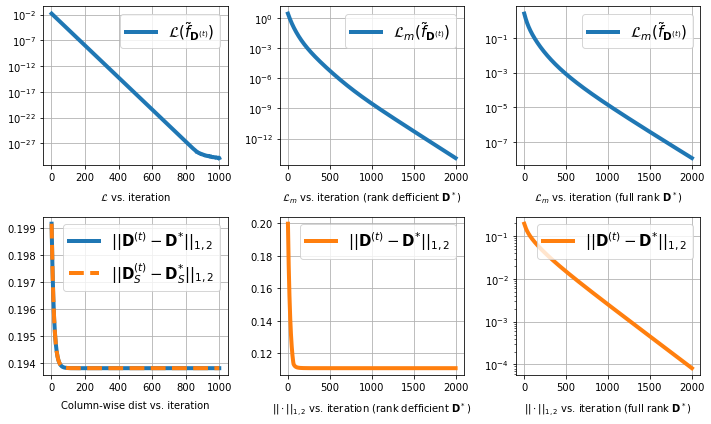

In [27]:

#--- Create a 2-row, 3-column figure ---#
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

#--- Plot each subplot ---#
ax = axes[0][0]
ax.semilogy(
    iterations_1, losses_1, label=r'$\mathcal{L}(\tilde{f}_{\mathbf{D}^{(t)}})$',
    linewidth=4,
    linestyle='-', color='C0'
)
ax.grid(True)
ax.legend()
ax.set_xlabel(r"$\mathcal{L}$ vs. iteration", labelpad=8)

ax = axes[1][0]
# Plot the "all columns" curve
ax.plot(
    iterations_1, max_col_dist_all_1, label=r'$\|\|\mathbf{D}^{(t)}-\mathbf{D}^{*}\|\|_{1,2}$',
    linewidth=4,
    linestyle='-', color='C0'
)
# Plot the "masked columns" curve
ax.plot(
    iterations_1, max_col_dist_masked_only_1, label=r'$\|\|\mathbf{D}_S^{(t)}-\mathbf{D}_S^{*}\|\|_{1,2}$',
    linewidth=4,
    linestyle='--', color='C1'
)
ax.grid(True)
ax.legend()
ax.set_xlabel(r"Column-wise dist vs. iteration", labelpad=8)

ax = axes[0][1]
ax.semilogy(
    iterations_2, losses_2, label=r'$\mathcal{L}_m(\tilde{f}_{\mathbf{D}^{(t)}})$',
    linewidth=4,
    linestyle='-', color='C0'
)
ax.grid(True)
ax.legend()
ax.set_xlabel(r"$\mathcal{L}_m$ vs. iteration (rank defficient $\mathbf{D}^*$)", labelpad=8)

ax = axes[1][1]
ax.plot(
    iterations_2, max_col_dist_all_2, label=r'$\|\|\mathbf{D}^{(t)}-\mathbf{D}^{*}\|\|_{1,2}$',
    linewidth=4,
    linestyle='-', color='C1'
)
ax.grid(True)
ax.legend()
ax.set_xlabel(r"$\|\|\cdot\|\|_{1,2}$ vs. iteration (rank defficient $\mathbf{D}^*$)", labelpad=8)

ax = axes[0][2]
ax.semilogy(
    iterations_2, losses_3, label=r'$\mathcal{L}_m(\tilde{f}_{\mathbf{D}^{(t)}})$',
    linewidth=4,
    linestyle='-', color='C0'
)
ax.grid(True)
ax.legend()
ax.set_xlabel(r"$\mathcal{L}_m$ vs. iteration (full rank $\mathbf{D}^*$)", labelpad=8)

ax = axes[1][2]
ax.semilogy(
    iterations_2, max_col_dist_all_3, label=r'$\|\|\mathbf{D}^{(t)}-\mathbf{D}^{*}\|\|_{1,2}$',
    linewidth=4,
    linestyle='-', color='C1'
)
ax.grid(True)
ax.legend()
ax.set_xlabel(r"$\|\|\cdot\|\|_{1,2}$ vs. iteration (full rank $\mathbf{D}^*$)", labelpad=8)
#--- Tight layout to make it compact, but leave space at the top for row titles ---#
#  (Adjust the top margin in `rect` if your row subtitles get cut off)
fig.tight_layout(rect=[0, 0, 1, 1])

#--- Add row subtitles using fig.text() ---
#    y-coordinates chosen so that each text line appears above its respective row.
#    Adjust these values to position them exactly where you want.
# fig.text(0.5, 0.95, "Subtitle for Row 1", ha='center', va='center', fontsize=14)
# fig.text(0.5, 0.45, "Subtitle for Row 2", ha='center', va='center', fontsize=14)


plt.savefig("paper_plot/synthetic_plot.pdf", format="pdf", dpi=300) 
#--- Show the final figure ---#
plt.show()